In [1]:
import pandas as pd
import ast

In [2]:
def upload_dataset():
    df = pd.read_csv("../data/movies_metadata_cleaned_v1.csv", index_col=0)
    required_columns = [
        "id",
        "imdb_id",
        "title",
        "genres",
        "original_title",
        "overview",
        "cast",
        "poster_path",
        "director",
    ]
    df = df[required_columns]

    df["combined_rows"] = df.apply(
        lambda x: f"The movie {x['title']} is directed by {x['director']} and has the following genres ({', '.join(ast.literal_eval(x['genres']))}) and the cast includes ({', '.join(ast.literal_eval(x['cast']))}) and the overview is {x['overview']}",
        axis=1,
    )
    return df

In [3]:
df = upload_dataset()

In [4]:
df[df["title"] == "Interstellar"]["overview"].values[0]

'Interstellar chronicles the adventures of a group of explorers who make use of a newly discovered wormhole to surpass the limitations on human space travel and conquer the vast distances involved in an interstellar voyage.'

In [5]:
df["combined_rows"][0]

/var/folders/4v/n05vgwdj65b8dkvc11yd9bzr0000gn/T/ipykernel_2554/2795503196.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df["combined_rows"][0]


"The movie Toy Story is directed by John Lasseter and has the following genres (animation, comedy, family) and the cast includes (Tom Hanks, Tim Allen, Don Rickles) and the overview is Led by Woody, Andy's toys live happily in his room until Andy's birthday brings Buzz Lightyear onto the scene. Afraid of losing his place in Andy's heart, Woody plots against Buzz. But when circumstances separate Buzz and Woody from their owner, the duo eventually learns to put aside their differences."

In [6]:
import os
from dotenv import load_dotenv

load_dotenv()

True

In [7]:
import requests

df = upload_dataset()

OMDP_API_KEY = os.getenv("OMDP_API_KEY")
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
QDRANT_URL = os.getenv("QDRANT_URL")


def get_poster(imdb_id: int, omdp_api_key: str = OMDP_API_KEY):
    url = f"http://www.omdbapi.com/?apikey={omdp_api_key}&i={imdb_id}"
    response = requests.get(url)
    data = response.json()
    print(data)
    return data

In [8]:
from qdrant_client import QdrantClient, models

In [9]:
client = QdrantClient(
    url=QDRANT_URL,
    api_key=os.getenv("QDRANT_API_KEY"),
)

client.get_collections()

CollectionsResponse(collections=[CollectionDescription(name='movies_metadata')])

In [8]:
combined_rows_list = df["combined_rows"].to_list()

In [10]:
from llama_index.embeddings.openai import OpenAIEmbedding

In [11]:
embed_model = OpenAIEmbedding(model="text-embedding-3-small", api_key=OPENAI_API_KEY)

In [ ]:
with open("embedded_combined_rows.txt", "r") as f:
    embedded_combined_rows = f.read()

In [ ]:
import json

embedded_combined_rows_list = json.loads(embedded_combined_rows)

In [ ]:
client.upload_points(
    collection_name="movies_metadata",
    points=[
        models.PointStruct(
            id=movies_df["id"],
            vector=embedded_combined_rows_list[idx],
        )
        for idx, movies_df in df.iterrows()
    ],
)

In [12]:
query = embed_model.get_text_embedding(
    "group of explorers who make use of a newly discovered wormhole to surpass the limitations on human space travel and conquer the vast distances involved in an interstellar voyage"
)

In [13]:
res = client.search(
    collection_name="movies_metadata",
    query_vector=query,
    limit=3,
)

In [14]:
res

[ScoredPoint(id=306963, version=416, score=0.44791332, payload={}, vector=None, shard_key=None),
 ScoredPoint(id=9570, version=50, score=0.42481244, payload={}, vector=None, shard_key=None),
 ScoredPoint(id=325263, version=529, score=0.4077306, payload={}, vector=None, shard_key=None)]

In [15]:
from IPython.display import Image, display

-----------------------------------
Wanderers
Wanderers is a vision of humanity's expansion into the Solar System, based on scientific ideas and concepts of what our future in space might look like, if it ever happens. The locations depicted in the film are digital recreations of actual places in the Solar System, built from real photos and map data where available.  Without any apparent story, other than what you may fill in by yourself, the idea with the film is primarily to show a glimpse of the fantastic and beautiful nature that surrounds us on our neighboring worlds - and above all, how it might appear to us if we were there.
imdb_id is: tt4075578
{'Title': 'Wanderers', 'Year': '2014', 'Rated': 'N/A', 'Released': '11 Oct 2014', 'Runtime': '4 min', 'Genre': 'Documentary, Animation, Short', 'Director': 'Erik Wernquist', 'Writer': 'Erik Wernquist', 'Actors': 'Carl Sagan', 'Plot': 'What if we, humans, were to expand beyond the strict bounds of our pale blue dot called planet Earth?',

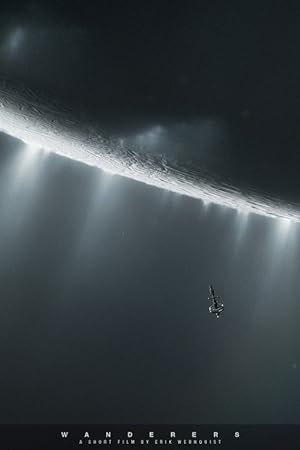

-----------------------------------
The Black Hole
The explorer craft U.S.S. Palomino is returning to Earth after a fruitless 18-month search for extra-terrestrial life when the crew comes upon a supposedly lost ship, the magnificent U.S.S. Cygnus, hovering near a black hole. The ship is controlled by Dr. Hans Reinhardt and his monstrous robot companion, Maximillian. But the initial wonderment and awe the Palomino crew feel for the ship and its resistance to the power of the black hole turn to horror as they uncover Reinhardt's plans.
imdb_id is: tt0078869
{'Title': 'The Black Hole', 'Year': '1979', 'Rated': 'PG', 'Released': '21 Dec 1979', 'Runtime': '98 min', 'Genre': 'Action, Sci-Fi', 'Director': 'Gary Nelson', 'Writer': 'Jeb Rosebrook, Bob Barbash, Richard H. Landau', 'Actors': 'Maximilian Schell, Anthony Perkins, Robert Forster', 'Plot': 'A research vessel finds a missing ship, commanded by a mysterious scientist, on the edge of a black hole.', 'Language': 'English', 'Country': 'U

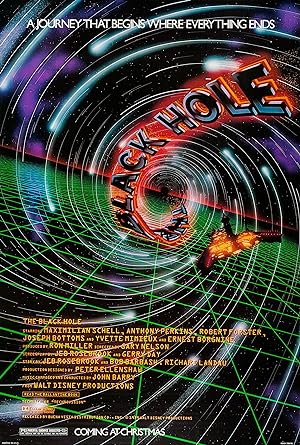

-----------------------------------
Journey to Space
A sweeping overview of humanity’s accomplishments in space, as well as our ongoing activities and future plans.
imdb_id is: tt4292554
{'Title': 'Journey to Space', 'Year': '2015', 'Rated': 'Unrated', 'Released': '26 Mar 2015', 'Runtime': '45 min', 'Genre': 'Documentary, Adventure, Sci-Fi', 'Director': 'Mark Krenzien', 'Writer': 'Mark Krenzien', 'Actors': 'Lindsay Aitchison, Serena Aunon-Chancellor, Chris Ferguson', 'Plot': 'An unveiling of a new era of unprecedented deep space exploration in dramatic giant screen film format.', 'Language': 'English', 'Country': 'United States', 'Awards': '1 win', 'Poster': 'https://m.media-amazon.com/images/M/MV5BZmQ2ZTliMGYtNjY2OS00YzIwLWJlMTctOGU0NGNmNzFhNGZlXkEyXkFqcGdeQXVyMTQxMzU0Nzk@._V1_SX300.jpg', 'Ratings': [{'Source': 'Internet Movie Database', 'Value': '6.5/10'}], 'Metascore': 'N/A', 'imdbRating': '6.5', 'imdbVotes': '853', 'imdbID': 'tt4292554', 'Type': 'movie', 'DVD': '02 Mar 2017', 'BoxO

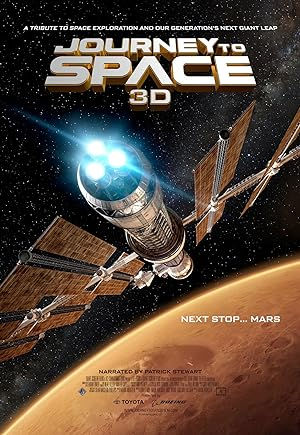

In [16]:
for movies in res:
    dataframe = df[df["id"] == movies.id]
    print("-" * 35)
    print(dataframe["title"].values[0])
    print(dataframe["overview"].values[0])
    print(f'imdb_id is: {dataframe["imdb_id"].values[0]}')
    display(Image(get_poster(dataframe["imdb_id"].values[0])["Poster"]))